## Importing Required Libraries

In this section, we import the libraries used for data manipulation, visualization, and machine learning.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import os
from PIL import Image

## Loading and Exploring the Dataset

We load the FER2013 dataset and explore its structure. This dataset contains grayscale facial expression images categorized into 7 emotions.

In [ ]:
from google.colab import files
files.upload()

In [3]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
import kagglehub

path = kagglehub.dataset_download("msambare/fer2013")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/fer2013


In [5]:
def load_dataset(base_path):
    X = []
    y = []
    class_names = sorted(os.listdir(base_path))
    label_map = {class_name: idx for idx, class_name in enumerate(class_names)}

    for class_name in class_names:
        class_dir = os.path.join(base_path, class_name)
        for file in os.listdir(class_dir):
            img_path = os.path.join(class_dir, file)
            try:
                img = Image.open(img_path).convert('L')
                img = img.resize((48, 48))
                img_array = np.array(img, dtype='float32') / 255.0
                X.append(img_array.flatten())
                y.append(label_map[class_name])
            except Exception as e:
                print("Hata:", e, "Dosya:", img_path)

    return np.array(X), np.array(y), label_map

In [6]:
train_path = "/kaggle/input/fer2013/train"
test_path = "/kaggle/input/fer2013/test"

X_train, y_train, label_map = load_dataset(train_path)
X_test, y_test, _ = load_dataset(test_path)

In [7]:
print("Labels:", label_map)
print("Number of Train Samples:", X_train.shape[0])
print("Number of Test Samples:", X_test.shape[0])

Labels: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
Number of Train Samples: 28709
Number of Test Samples: 7178


## Principal Component Analysis (PCA) - Manual Implementation

In this section, we implement PCA from scratch. This involves computing the covariance matrix, extracting eigenvectors, and reducing dimensionality of the dataset.

In [8]:
def apply_pca(X, num_components=2):
    X_meaned = X - np.mean(X, axis=0)

    cov_mat = np.cov(X_meaned, rowvar=False)

    eigen_values, eigen_vectors = np.linalg.eigh(cov_mat)

    sorted_idx = np.argsort(eigen_values)[::-1]

    eigen_vectors = eigen_vectors[:, sorted_idx]
    eigen_vectors = eigen_vectors[:, :num_components]

    X_reduced = np.dot(X_meaned, eigen_vectors)
    return X_reduced, eigen_vectors, np.mean(X, axis=0)

In [9]:
X_train_pca, pca_projection_matrix, X_train_mean = apply_pca(X_train, num_components=150)

X_test_centered = X_test - X_train_mean
X_test_pca = np.dot(X_test_centered, pca_projection_matrix)

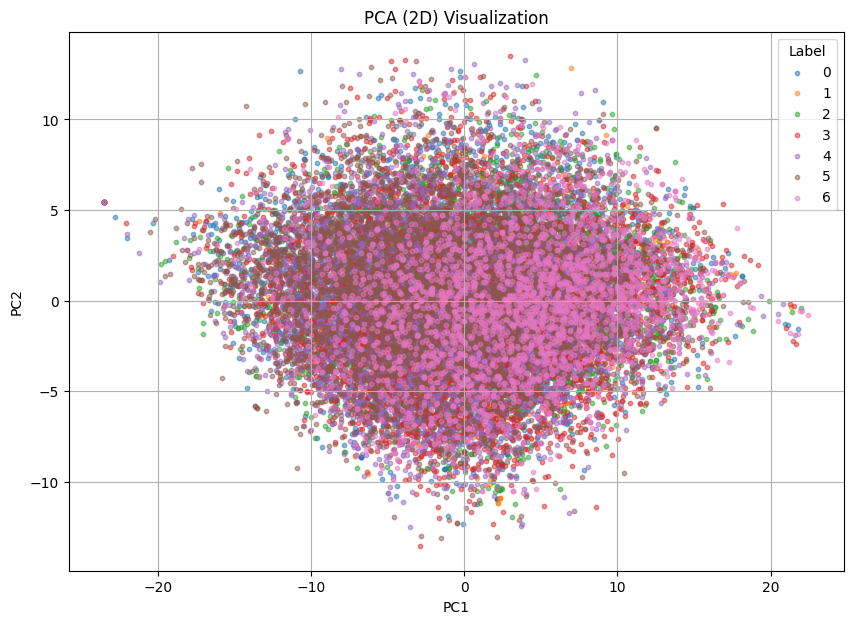

In [10]:
plt.figure(figsize=(10, 7))
for label in np.unique(y_train):
    idx = y_train == label
    plt.scatter(X_train_pca[idx, 0], X_train_pca[idx, 1], label=label, alpha=0.5, s=10)
plt.legend(title="Label")
plt.title("PCA (2D) Visualization")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()

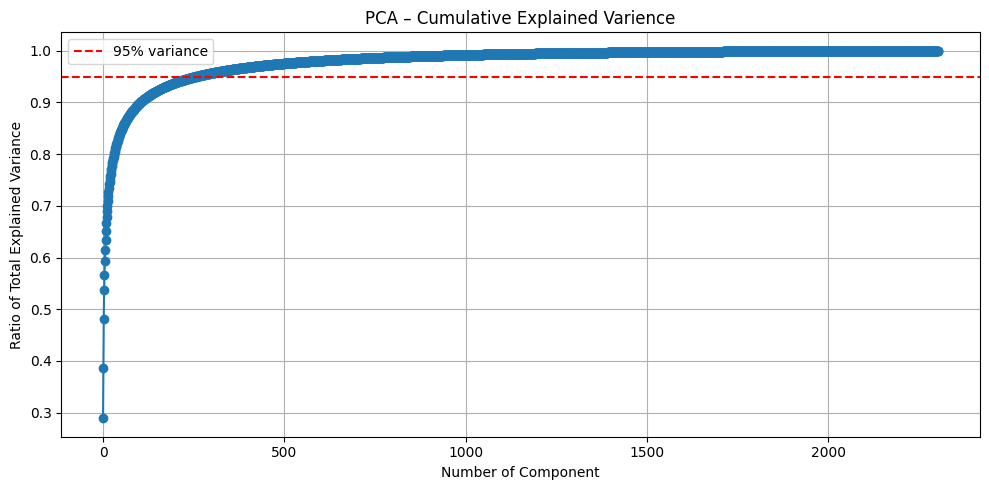

Number of components required to explain 95% of the variance: 257


In [11]:
def explained_variance_plot(X):
    X_meaned = X - np.mean(X, axis=0)

    cov_mat = np.cov(X_meaned, rowvar=False)

    eigen_vals, _ = np.linalg.eigh(cov_mat)

    sorted_eigen_vals = np.sort(eigen_vals)[::-1]

    total = np.sum(sorted_eigen_vals)
    explained_variance_ratio = sorted_eigen_vals / total
    cumulative_variance = np.cumsum(explained_variance_ratio)

    plt.figure(figsize=(10, 5))
    plt.plot(cumulative_variance, marker='o')
    plt.axhline(y=0.95, color='r', linestyle='--', label='95% variance')
    plt.title("PCA – Cumulative Explained Varience")
    plt.xlabel("Number of Component")
    plt.ylabel("Ratio of Total Explained Variance")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    num_components_95 = np.argmax(cumulative_variance >= 0.95) + 1
    print(f"Number of components required to explain 95% of the variance: {num_components_95}")

explained_variance_plot(X_train)

## Linear Discriminant Analysis (LDA) - Manual Implementation

LDA is applied after PCA to maximize class separability. We manually compute scatter matrices and solve the generalized eigenvalue problem.

In [12]:
def apply_lda(X, y, num_components=2):
    class_labels = np.unique(y)
    n_features = X.shape[1]

    mean_overall = np.mean(X, axis=0)
    Sw = np.zeros((n_features, n_features))
    Sb = np.zeros((n_features, n_features))

    for c in class_labels:
        X_c = X[y == c]
        mean_c = np.mean(X_c, axis=0)

        Sw += np.dot((X_c - mean_c).T, (X_c - mean_c))

        n_c = X_c.shape[0]
        mean_diff = (mean_c - mean_overall).reshape(n_features, 1)
        Sb += n_c * np.dot(mean_diff, mean_diff.T)

    eig_vals, eig_vecs = np.linalg.eig(np.linalg.pinv(Sw).dot(Sb))

    sorted_indices = np.argsort(np.abs(eig_vals))[::-1]
    eig_vecs = eig_vecs[:, sorted_indices]

    W = eig_vecs[:, :num_components]

    X_lda = np.dot(X, W.real)
    return X_lda, W.real

In [13]:
X_train_lda, lda_projection_matrix = apply_lda(X_train, y_train, num_components=6)
X_test_lda = np.dot(X_test, lda_projection_matrix)

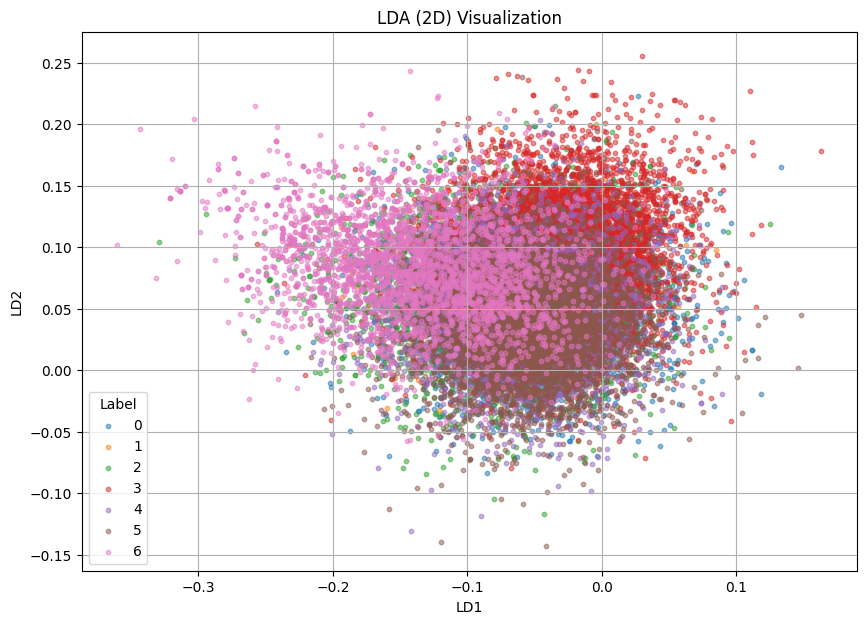

In [14]:
plt.figure(figsize=(10, 7))
for label in np.unique(y_train):
    idx = y_train == label
    plt.scatter(X_train_lda[idx, 0], X_train_lda[idx, 1], label=label, alpha=0.5, s=10)
plt.legend(title="Label")
plt.title("LDA (2D) Visualization")
plt.xlabel("LD1")
plt.ylabel("LD2")
plt.grid(True)
plt.show()

## Training Classification Models

We train classical ML models (Logistic Regression, k-NN, Random Forest) using the reduced features. Each model is evaluated separately.

In [15]:
from sklearn.linear_model import LogisticRegression

clf_lda = LogisticRegression(max_iter=1000)
clf_pca = LogisticRegression(max_iter=1000)
clf_lda.fit(X_train_lda, y_train)
clf_pca.fit(X_train_pca, y_train)
y_pred_lda = clf_lda.predict(X_test_lda)
y_pred_pca = clf_pca.predict(X_test_pca)

## Model Evaluation and Accuracy Comparison

We evaluate all models using accuracy scores. The best performance is achieved by PCA + Random Forest.


Accuracy Score of LDA + LogReg: 0.3457787684591808


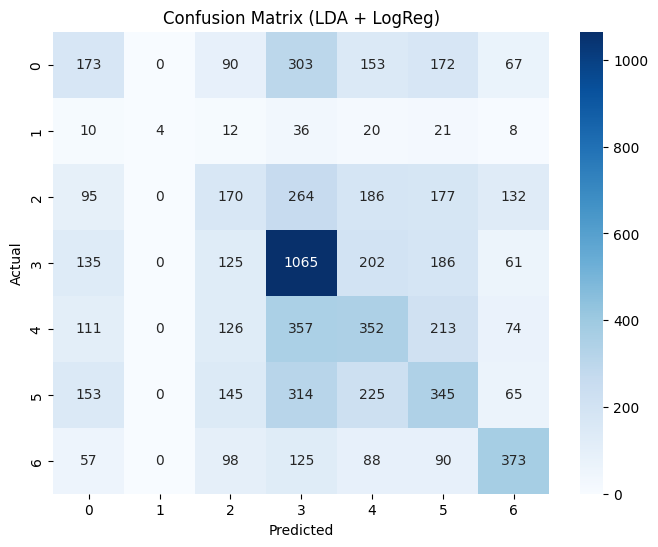

In [16]:
print("Accuracy Score of LDA + LogReg:", accuracy_score(y_test, y_pred_lda))

plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_test, y_pred_lda), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (LDA + LogReg)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

Accuracy Score of PCA + LogReg: 0.3779604346614656


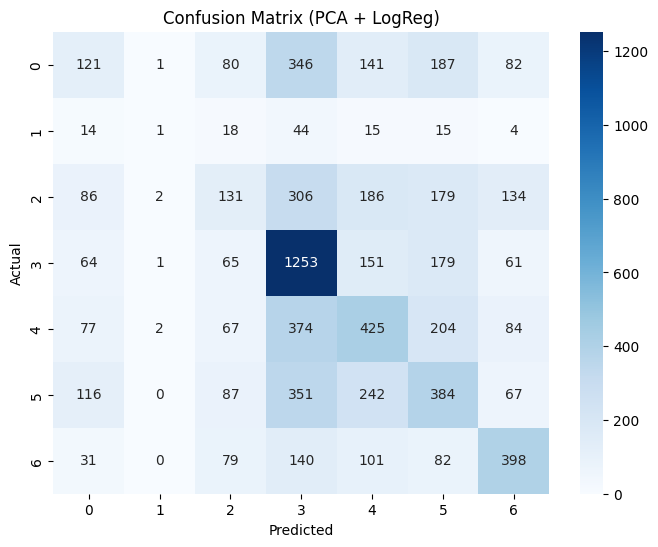

In [17]:
print("Accuracy Score of PCA + LogReg:", accuracy_score(y_test, y_pred_pca))

plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_test, y_pred_pca), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (PCA + LogReg)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

Accuracy Score of PCA + 3-NN: 0.34633602674839786


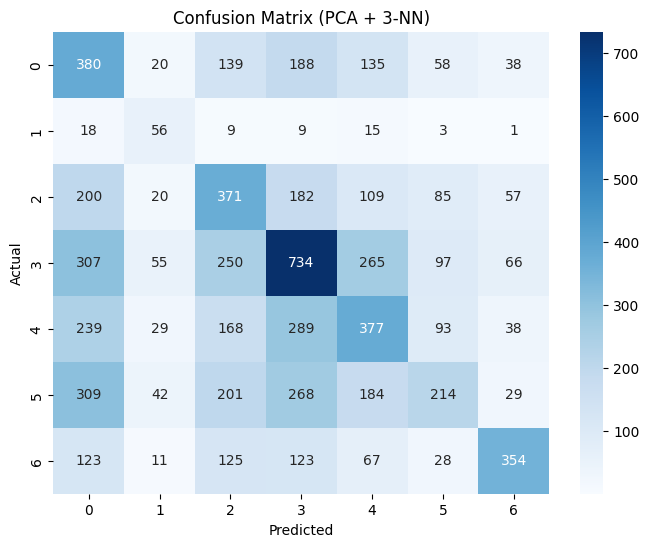

In [18]:
from sklearn.neighbors import KNeighborsClassifier


knn_clf = KNeighborsClassifier(n_neighbors=3)
knn_clf.fit(X_train_pca, y_train)

y_pred_knn = knn_clf.predict(X_test_pca)

print("Accuracy Score of PCA + 3-NN:", accuracy_score(y_test, y_pred_knn))

plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_test, y_pred_knn), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (PCA + 3-NN)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

Accuracy Score of PCA + Random Forest: 0.42407355809417663


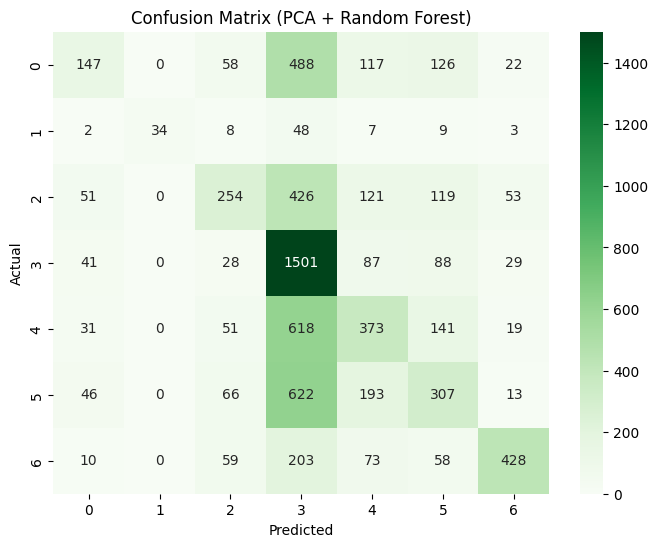

In [19]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train_pca, y_train)

y_pred_rf = rf_clf.predict(X_test_pca)

print("Accuracy Score of PCA + Random Forest:", accuracy_score(y_test, y_pred_rf))

plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Greens')
plt.title("Confusion Matrix (PCA + Random Forest)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

Accuracy Score of LDA + Random Forest: 0.3715519643354695


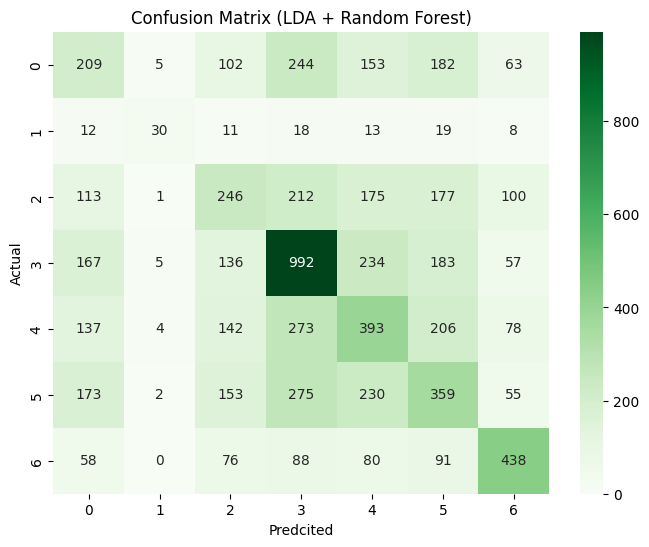

In [20]:
rf_lda = RandomForestClassifier(n_estimators=100, random_state=42)
rf_lda.fit(X_train_lda, y_train)

y_pred_lda_rf = rf_lda.predict(X_test_lda)

print("Accuracy Score of LDA + Random Forest:", accuracy_score(y_test, y_pred_lda_rf))

plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_test, y_pred_lda_rf), annot=True, fmt='d', cmap='Greens')
plt.title("Confusion Matrix (LDA + Random Forest)")
plt.xlabel("Predcited")
plt.ylabel("Actual")
plt.show()

## Conclusion

- PCA + Random Forest achieved the highest accuracy: **42.4%**
- Manual implementation of PCA and LDA enhanced understanding of dimensionality reduction.
- Emotion classes with similar features were harder to distinguish (e.g., Fear vs. Neutral).
